# CEG3004:DSP Mini-Project: Environmental Sound Classification

**You will improve the DSP feature pipeline and the ML model.**

✅ Train on: `data/train` (labeled)  
✅ Predict on: `data/submission` (unlabeled; includes `__clean`, `__noisy`, `__bandlimited`)  
✅ Submit: 1) The model in `<GROUP_ID>_model.joblib` and 2) `<GROUP_ID>_predictions.csv` to xsite Dropbox

---

## Student TODO Map (what you should improve)

1. **Preprocessing** (normalization, trimming/padding, filtering etc)
2. **Feature extraction** (MFCC/log-mel/spectral features, CMVN, deltas, pooling)
3. **Modeling** (classifier choice + hyperparameters)
4. **Robustness** (augmentation ideas: noise, random bandpass, gain)

All places you should edit are marked as:

> **🟨 STUDENT TODO**


In [ ]:
#@title Enter Your Project Group Number
#@markdown This should be as per xcite Group (e.g. Pr_1)
GROUP_ID = "Pr_3" #@param {type:"string"}

if not GROUP_ID:
  raise ValueError("You must enter a Group ID to proceed. Please run this cell again.")

print(f"Welcome Group, {GROUP_ID}!")

Welcome Group, Pr_3!


In [ ]:
#@title 1) Setup (install deps)
!pip -q install numpy scipy pandas scikit-learn librosa soundfile tqdm


In [ ]:
#@title 2) Download dataset ZIP from Google Drive
!pip -q install gdown

import gdown
import zipfile
import os

FILE_ID = "1bceZrbOMPSXTTTMBx8XqDBwsSMussPHj"
zip_path = "CEG3004_Project_Data.zip"

gdown.download(f"https://drive.google.com/uc?id={FILE_ID}", zip_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1bceZrbOMPSXTTTMBx8XqDBwsSMussPHj
From (redirected): https://drive.google.com/uc?id=1bceZrbOMPSXTTTMBx8XqDBwsSMussPHj&confirm=t&uuid=1e6f42d0-c6a9-4e2d-bdc5-6f209002db74
To: /content/CEG3004_Project_Data.zip
100%|██████████| 787M/787M [00:13<00:00, 57.4MB/s]


'CEG3004_Project_Data.zip'

In case the above code fails due to overload, you can manually download the data from the link [here](https://drive.google.com/file/d/1bceZrbOMPSXTTTMBx8XqDBwsSMussPHj/view?usp=sharing) and upload to colab using folder icon on the left panel. Please see the picture below


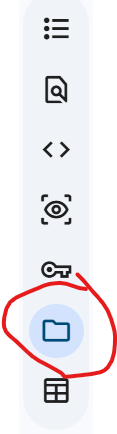

In [ ]:
#Extract the folder
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall("/content")

print("Dataset extracted.")

Dataset extracted.


In [ ]:
#@title 3) Set paths (EDIT ME IF REQUIRED)
import os

# 🟨 STUDENT TODO: Set this to your Drive path
# Example: '/content/drive/MyDrive/data'
DATA_ROOT = "/content"

TRAIN_DIR = os.path.join(DATA_ROOT, 'data', 'train')
SUBMISSION_DIR = os.path.join(DATA_ROOT, 'data', 'submission')

print('TRAIN_DIR:', TRAIN_DIR)
print('SUBMISSION_DIR:', SUBMISSION_DIR)
assert os.path.exists(TRAIN_DIR), 'Train directory not found'
assert os.path.exists(SUBMISSION_DIR), 'Submission directory not found'


TRAIN_DIR: /content/data/train
SUBMISSION_DIR: /content/data/submission


In [ ]:
#@title 🔍 Dataset Safety Check (DO NOT MODIFY)

import os
import pandas as pd

print("Checking dataset structure...\n")

train_dir = os.path.join(DATA_ROOT, "data", "train")
submission_dir = os.path.join(DATA_ROOT, "data", "submission")

assert os.path.exists(train_dir), "❌ Missing data/train folder"
assert os.path.exists(submission_dir), "❌ Missing data/submission folder"

labels_path = os.path.join(train_dir, "labels.csv")
meta_path = os.path.join(submission_dir, "metadata.csv")

assert os.path.exists(labels_path), "❌ Missing labels.csv in train"
assert os.path.exists(meta_path), "❌ Missing metadata.csv in submission"

train_audio_dir = os.path.join(train_dir, "audio")
sub_audio_dir = os.path.join(submission_dir, "audio")

assert os.path.exists(train_audio_dir), "❌ Missing train/audio folder"
assert os.path.exists(sub_audio_dir), "❌ Missing submission/audio folder"

train_wavs = [f for f in os.listdir(train_audio_dir) if f.endswith(".wav")]
sub_wavs = [f for f in os.listdir(sub_audio_dir) if f.endswith(".wav")]

assert len(train_wavs) > 0, "❌ No training WAV files found"
assert len(sub_wavs) > 0, "❌ No submission WAV files found"

labels_df = pd.read_csv(labels_path)
meta_df = pd.read_csv(meta_path)

print(f"✅ Train samples: {len(labels_df)}")
print(f"✅ Submission samples: {len(meta_df)}")
print(f"✅ Train WAV files: {len(train_wavs)}")
print(f"✅ Submission WAV files: {len(sub_wavs)}")

# Check 3x robustness structure
base_ids = labels_df["clip_id"].astype(str)
expected_submission = len(base_ids) * 3

if len(meta_df) == expected_submission:
    print("✅ Submission contains clean/noisy/bandlimited versions (3x check passed)")
else:
    print("⚠️ Submission count does not match expected 3x structure")

print("\n🎉 Dataset structure looks correct.")


Checking dataset structure...

✅ Train samples: 1200
✅ Submission samples: 1200
✅ Train WAV files: 1200
✅ Submission WAV files: 1200
⚠️ Submission count does not match expected 3x structure

🎉 Dataset structure looks correct.


In [ ]:
#@title 4) Imports
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa
import soundfile as sf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score


## Load training labels

In [ ]:
labels_csv = os.path.join(TRAIN_DIR, 'labels.csv')
audio_train_dir = os.path.join(TRAIN_DIR, 'audio')

df = pd.read_csv(labels_csv)
df['clip_id'] = df['clip_id'].astype(str)
df['label'] = df['label'].astype(str)
print('Train rows:', len(df))
df.head()


Train rows: 1200


,clip_id,label
0,1-100032-A-0,dog
1,1-100038-A-14,chirping_birds
2,1-100210-A-36,vacuum_cleaner
3,1-100210-B-36,vacuum_cleaner
4,1-101296-A-19,thunderstorm


In [ ]:
#@title ✅ Interactive Audio Player with Visualizations
import IPython.display as ipd
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import librosa.display

def play_audio_and_visualize(clip_id):
    row = df[df['clip_id'] == clip_id].iloc[0]
    path = os.path.join(audio_train_dir, f'{clip_id}.wav')
    y, sr = librosa.load(path, sr=16000)

    print(f"Clip ID: {clip_id} | Label: {row['label']}")

    # Display audio player BEFORE the plots
    display(ipd.Audio(y, rate=sr))

    # Visualization
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

    # Time Domain: Waveform
    librosa.display.waveshow(y, sr=sr, ax=ax[0])
    ax[0].set(title='Time Domain (Waveform)', xlabel='Time (s)', ylabel='Amplitude')

    # Frequency Domain: Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=ax[1])
    ax[1].set(title='Frequency Domain (Spectrogram)')

    plt.tight_layout()
    plt.show()

clip_selector = widgets.Dropdown(
    options=df['clip_id'].head(100).tolist(),
    value=df['clip_id'].iloc[0],
    description='Train Clip:',
)

widgets.interact(play_audio_and_visualize, clip_id=clip_selector)

interactive(children=(Dropdown(description='Train Clip:', options=('1-100032-A-0', '1-100038-A-14', '1-100210-…

<function __main__.play_audio_and_visualize(clip_id)>

# 🧩 DSP Pipeline

Below are baseline functions.

Everything marked **STUDENT TODO** is where you should improve the pipeline.


In [ ]:
#@title 5) Audio loading + preprocessing

def load_audio(path, sr=16000):
    """Load mono audio, resample to sr."""
    y, sr_out = librosa.load(path, sr=sr, mono=True)
    y = np.nan_to_num(y).astype(np.float32)
    return y, sr_out

def preprocess_audio(y, sr):
    """Basic preprocessing.

    🟨 STUDENT TODO: Improve this function.
    Ideas:
      - peak or RMS normalization
      - trim leading/trailing silence
      - fixed-length padding/truncation (e.g., 5s)
      - pre-emphasis filter
    """

    #1️ Trim leading/trailing silence
    y, _ = librosa.effects.trim(y, top_db=30)

    #2️ Peak normalization
    peak = np.max(np.abs(y))
    if peak > 0:
        y = y / peak

    #3 Fixed length (5 seconds = 80000 samples)
    target_len = 5 * sr  # 80000 if sr=16000

    if len(y) < target_len:
        # Pad with zeros
        y = np.pad(y, (0, target_len - len(y)))
    else:
        # Truncate
        y = y[:target_len]

    #4 Optional: Pre-emphasis (boost high freq)
    y = np.append(y[0], y[1:] - 0.97 * y[:-1])
    # Baseline: do nothing
    return y


In [ ]:
#@title 6) Feature extraction (baseline: MFCC stats)

def features_mfcc_stats(y, sr, n_mfcc=20, n_fft=1024, hop=256):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop)
    d1 = librosa.feature.delta(mfcc)
    d2 = librosa.feature.delta(mfcc, order=2)

    def stats(M):
        return np.concatenate([M.mean(axis=1), M.std(axis=1)], axis=0)

    return np.concatenate([stats(mfcc), stats(d1), stats(d2)], axis=0).astype(np.float32)

def extract_features(path, sr=16000):
    """Return a 1D feature vector for one clip.

    🟨 STUDENT TODO: Improve feature extraction here.
    Options:
      - log-mel spectrogram stats
      - spectral centroid/bandwidth/rolloff/flux
      - CMVN on MFCC/log-mel
      - multi-window features
      - robust pooling (median, percentiles)
    """
    y, sr = load_audio(path, sr=sr)
    y = preprocess_audio(y, sr)

    features =[]

    # Baseline MFCC stats
    mfcc_feat = features_mfcc_stats(y, sr)
    features.append(mfcc_feat)

    # Add log-mel stats
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
    logmel = librosa.power_to_db(mel)

    features.append(logmel.mean(axis=1))
    features.append(logmel.std(axis=1))

    # Add spectral features
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)

    for F in [centroid, bandwidth, rolloff, zcr]:
        features.append(F.mean(axis=1))
        features.append(F.std(axis=1))

    return np.concatenate(features).astype(np.float32)


In [ ]:
#@title 7) Build training feature matrix (may take a few minutes)

X, y = [], []
classes = sorted(df['label'].unique().tolist())
label_to_idx = {c:i for i,c in enumerate(classes)}
idx_to_label = {i:c for c,i in label_to_idx.items()}

for _, r in tqdm(df.iterrows(), total=len(df)):
    clip_id = r['clip_id']
    wav_path = os.path.join(audio_train_dir, f'{clip_id}.wav')
    X.append(extract_features(wav_path))
    y.append(label_to_idx[r['label']])

X = np.stack(X, axis=0)
y = np.array(y, dtype=np.int64)
print('X shape:', X.shape, 'num_classes:', len(classes))


100%|██████████| 1200/1200 [00:52<00:00, 22.74it/s]

X shape: (1200, 256) num_classes: 50


# 🧠 Model Training

Baseline = Logistic Regression.

🟨 **STUDENT TODO:** You can replace this with SVM, RandomForest, GradientBoosting, etc.


In [ ]:
#@title 8) Train/Validation + Baseline model
import joblib
from google.colab import files
from sklearn.svm import SVC #Using SVM to perform model training

X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 🟨 STUDENT TODO: Change model/hyperparameters
model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced'))
])

model.fit(X_tr, y_tr)
y_pred = model.predict(X_va)

print(classification_report(y_va, y_pred, target_names=[idx_to_label[i] for i in range(len(classes))]))
print('Macro-F1:', f1_score(y_va, y_pred, average='macro'))

# Save the model locally
model_filename = GROUP_ID + '_model'+'.joblib'
joblib.dump(model, model_filename)
print(f'Model saved as {model_filename}. Downloading to your computer...')
files.download(model_filename)

                  precision    recall  f1-score   support

        airplane       0.00      0.00      0.00         5
       breathing       0.40      0.80      0.53         5
  brushing_teeth       0.67      0.80      0.73         5
     can_opening       1.00      0.80      0.89         5
        car_horn       0.25      0.20      0.22         5
             cat       0.67      0.40      0.50         5
        chainsaw       0.57      0.80      0.67         5
  chirping_birds       0.83      1.00      0.91         5
    church_bells       0.75      0.60      0.67         5
        clapping       0.83      1.00      0.91         5
     clock_alarm       0.67      0.40      0.50         5
      clock_tick       0.67      0.40      0.50         5
        coughing       0.00      0.00      0.00         5
             cow       0.43      0.75      0.55         4
  crackling_fire       0.67      0.80      0.73         5
        crickets       0.50      0.60      0.55         5
            c

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 🧪 (Optional) Training-time augmentation

If you want to improve robustness, add augmentation in feature extraction.

🟨 **STUDENT TODO:** Implement noise/bandpass/gain augmentation during training.

Tip: you can augment the waveform `y` before computing features.


In [ ]:
#@title 9) Load submission metadata

sub_meta = pd.read_csv(os.path.join(SUBMISSION_DIR, 'metadata.csv'))
sub_meta['clip_id'] = sub_meta['clip_id'].astype(str)
audio_sub_dir = os.path.join(SUBMISSION_DIR, 'audio')
print('Submission rows:', len(sub_meta))
sub_meta.head()


Submission rows: 1200


,clip_id
0,5-103415-A-2__clean
1,5-103416-A-2__clean
2,5-103418-A-2__clean
3,5-103420-A-2__clean
4,5-103421-A-2__clean


In [ ]:
#@title 10) Predict on submission set and write CSV
from google.colab import files

OUT_CSV = f'{GROUP_ID}_predictions.csv' # 🟨 STUDENT TODO: Ensure You have entered the correct ID earlier

pred_rows = []
for _, r in tqdm(sub_meta.iterrows(), total=len(sub_meta)):
    clip_id = r['clip_id']
    wav_path = os.path.join(audio_sub_dir, f'{clip_id}.wav')
    feat = extract_features(wav_path)
    pred_idx = int(model.predict(feat.reshape(1, -1))[0])
    pred_label = idx_to_label[pred_idx]
    pred_rows.append((clip_id, pred_label))

out = pd.DataFrame(pred_rows, columns=['clip_id', 'predicted_label'])
out.to_csv(OUT_CSV, index=False)

print(f'Predictions saved to {OUT_CSV}. Downloading to your computer...')
files.download(OUT_CSV)

100%|██████████| 1200/1200 [00:49<00:00, 24.21it/s]

Predictions saved to Pr_3_predictions.csv. Downloading to your computer...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ✅ Generate predictions.csv (THIS IS WHAT YOU SUBMIT)

This will run your feature extractor + model on every clip in `data/submission/audio`.

Make sure your output file name includes your team ID.


## 📤 How to submit
Upload to the model file (.joblib) and the predictions (.csv) to your xsite Dropbox.

**You only submit your model and prediction CSV and not the code.**
